In [3]:
! pip install scikit-plot

In [52]:
import pickle
import numpy as np
from abc import ABC, abstractmethod
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import scikitplot as skplt
import matplotlib.pyplot as plt

In [64]:
class BaseTagger(ABC):
    @abstractmethod
    def get_tags(self, texts):
        pass

class Tagger(BaseTagger):
    def __init__(self, classification_threshold=0.2, weights_file="W.pik"):

        self.classification_threshold = classification_threshold

        vect = CountVectorizer()
        tfidf = TfidfTransformer()
        self.clf = SGDClassifier(learning_rate='adaptive', eta0=0.1, loss='modified_huber', penalty='elasticnet',
                                tol=1e-5, alpha=1e-5, max_iter=50, early_stopping=True, random_state=42)

        self.classifier = make_pipeline(vect, tfidf, self.clf)

        twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
        self.twenty_test = twenty_test
        self.targets = twenty_test.target_names
        twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
        self.twenty_train = twenty_train
        
        try:
            self.classifier = pickle.load(open(weights_file, 'rb'))
        except FileNotFoundError as error:            
            self.classifier = self.classifier.fit(twenty_train.data, twenty_train.target)            
            pickle.dump(self.classifier, open(weights_file, 'wb'))

    def get_tags(self, texts):
        tags = []
        tag_scores = []
        for text in texts:
            predictions = self.classifier.predict_proba([text])[0].tolist()
            sorted_scores = [(predictions[i], predictions.index(predictions[i])) for i in range(len(predictions))]
            sorted_scores = sorted(sorted_scores, reverse=True, key=lambda x: x[0])
            valid_predictions = []
            valid_predictions_scores = []

            for v in range(len(sorted_scores)):
                if sorted_scores[v][0] >= self.classification_threshold:
                    valid_predictions.append(self.targets[sorted_scores[v][1]])
                    valid_predictions_scores.append(sorted_scores[v][0])
            tags.append(valid_predictions)          

        return tags

    def score(self):
        preds = self.classifier.predict(self.twenty_test.data)
        print(f"\nModel score:{np.mean(preds == self.twenty_test.target):.2f}\n")

    def plot_roc(self):
        y_probas = self.classifier.predict_proba(self.twenty_test.data)
        skplt.metrics.plot_roc(self.twenty_test.target, y_probas, figsize=(10, 6))
        plt.grid()
        plt.show()

tagger = Tagger()        
txt = ["Holy bible and God", "Computer design", "Space, planet, star", "Water"]
print(f"Taggers:\n {tagger.get_tags(txt)}")

Taggers:
 [['soc.religion.christian', 'alt.atheism'], ['sci.electronics'], ['sci.space'], ['sci.med']]


# SCORE:


Model score:0.85



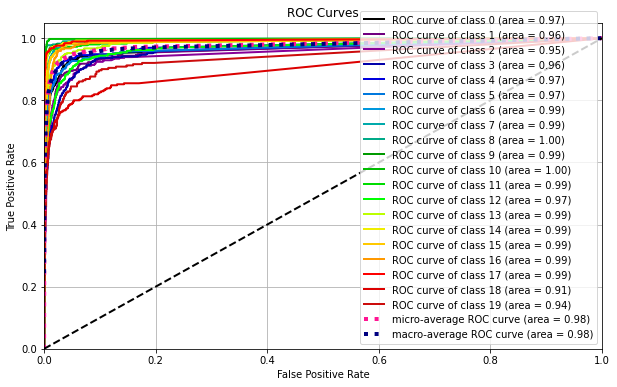

In [65]:
tagger.score()
tagger.plot_roc()